# Analyze pendulum data
Use this notebook to quickly test whether your pendulum data makes sense!

In [45]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats

sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

In [28]:
# Example file location
filename_example = 'data_pendulum_example/timer_output.dat'

## Data reader

In [29]:
# Read in data
def read_data(filename):
    dat = np.genfromtxt(filename, delimiter='\t', names=('n', 't_s'))
    return dat

## Read and plot the data

In [30]:
data_example = read_data(filename_example)
n, t = data_example['n'][2:], data_example['t_s'][2:]

#fit function
def lin_funk(x,T,b):
    return T*x+b

#fit data with Minuit
chi2 = Chi2Regression(lin_funk, n, t)

minuit = Minuit(chi2, T=3, b=0)
minuit.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1594                     │              Nfcn = 34               │
│ EDM = 7.25e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ T    │   2.734   │   0.006   │            │            │         │         │       │
│ 1 │ b    │   -4.36   │   0.26    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        T        b │
├───┼───────────────────┤
│ T │ 3.99e-05 -0.00144 │
│ b │ -0.00144   0.0666 │
└───┴───────────────────┘

In [31]:
T_fit , b_fit = minuit.values

In [173]:
print(T_fit)
# Plotting
sig_t = minuit.errors[0]     # Set your own values...
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), gridspec_kw={'height_ratios':[4,1]}, sharex=True)

ax[0].set_title('Pendulum period fit')
ax[0].errorbar(n, t, yerr=sig_t, color='lime', fmt='.',markersize =9, label='Data', capsize=6, ecolor='k',markeredgecolor='k')
ax[0].plot(n, lin_funk(n, T_fit, b_fit), color='r', label=f'Chi2 fit')
ax[0].set_xlabel('Timing measurement number', fontsize=12)
ax[0].set_ylabel('Time elapsed (s)', fontsize=12)
ax[0].set(xlim=(0, n[-1]+np.ediff1d(n)[0]), ylim=(0, t[-1]+np.ediff1d(t)[0]))
ax[0].legend(fontsize=12) , ax[0].grid()
ax[0].set_position([0.1, 0.3, 0.8, 0.6])


residuals = t-lin_funk(n, T_fit, b_fit)
ax[1].errorbar(n, residuals, yerr=sig_t, color='lime', fmt='.',markersize =9, label='Data', capsize=6, ecolor='k',markeredgecolor='k')
ax[1].set_xlabel('Timing measurement number', fontsize=12) 
ax[1].set_ylabel('Residuals', fontsize=12)
ax[1].axhline(0, color='r', linestyle='--') , ax[1].grid()
ax[1].set_position([0.1, 0.1, 0.8, 0.2]) 

d = {'Data Points': len(n),
        'Fitted Period': round(T_fit,3),
        'Sigma Period': round(sig_t,3)
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.78, text, ax[0], fontsize=15);
plt.close()


2.7335449078139993


In [120]:
Nbins = 13
xmin, xmax = -0.2, 0.2
bwidth = (xmax-xmin)/Nbins
#numpy histogram

hist , bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1:] - bin_edges[:-1]


#remove empty bins
mask = hist != 0
hist = hist[mask]
bin_centers = bin_centers[mask]
bin_width = bin_width[mask]



#fit a gaussian to the residuals histogram
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

chi2_gauss = Chi2Regression(gauss, bin_centers, hist, bin_width)

minuit_gauss = Minuit(chi2_gauss, mu=0, sigma=0.05, A=8)
minuit_gauss.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2777                       │              Nfcn = 84               │
│ EDM = 0.000123 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  3.65e-3  │  0.07e-3  │            │            │         │         │       │
│ 1 │ sigma │ 48.07e-3  │  0.08e-3  │            │            │         │         │       │
│ 2 │ A     │  17.115   │   0.023   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │        mu     sigma         A │
├───────┼───────────────────────────────┤
│    mu │  5.45e-09 -9.78e-11  2.09e-08 │
│ sigma │ -9.78e-11  6.01e-09 -1.06e-06 │
│     A │  2.09e-08 -1.06e-06  0.000529 │
└───────┴───────────────────────────────┘

In [174]:
mu_res_fit , sigma_res_fit , A_res_fit = minuit_gauss.values

x_fit = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax.hist(residuals, bins=Nbins, range=(xmin,xmax), color='k', histtype='step', label='Residuals')
ax.plot(x_fit, gauss(x_fit, mu_res_fit, sigma_res_fit, A_res_fit), color='r', label=f'Gauss:  $\sigma$ = {sigma_res_fit:.3f}')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set(xlim=(xmin, xmax))
ax.legend(fontsize=10) , ax.grid()
plt.close()
minuit_gauss.fval

2776.773705761762

In [122]:
# fit the data again using the sigma of the gaussian as the error on the data points
chi2 = Chi2Regression(lin_funk, n, t, sigma_res_fit)

minuit = Minuit(chi2, T=3, b=0)
minuit.migrad()

final_T_fit , final_b_fit = minuit.values
final_T_fit_err , final_b_fit_err = minuit.errors




0.0

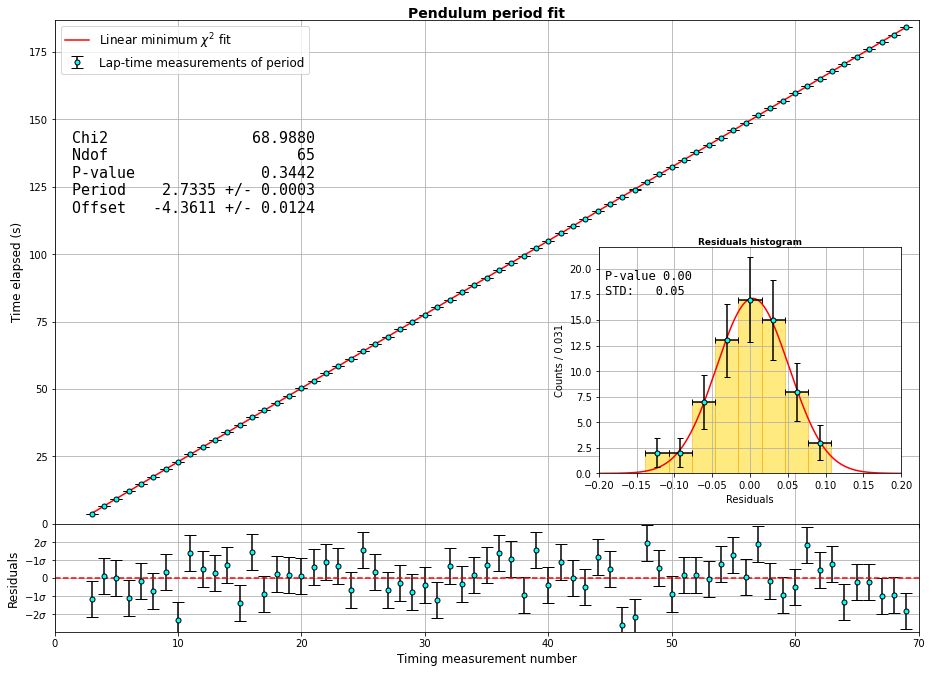

In [172]:
# plt.style.use('classic')

# Plot the data and the fit
sig_t = minuit.errors[0]    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), gridspec_kw={'height_ratios':[4,1]}, sharex=True)

ax[0].set_title('Pendulum period fit',fontsize=14, pad=2, color='k', fontweight='bold')
ax[0].errorbar(n, t, yerr=final_T_fit_err, color='cyan', fmt='.',markersize =10, label='Lap-time measurements of period', capsize=6, ecolor='k',markeredgecolor='k')
ax[0].plot(n, lin_funk(n, T_fit, b_fit), color='r', label=r'Linear minimum $\chi^2$ fit')
ax[0].set_xlabel('Timing measurement number', fontsize=12)
ax[0].set_ylabel('Time elapsed (s)', fontsize=12)
ax[0].set(xlim=(0, n[-1]+np.ediff1d(n)[0]), ylim=(0, t[-1]+np.ediff1d(t)[0]))
ax[0].legend(fontsize=12,loc = 'upper left') , ax[0].grid()
ax[0].set_position([0.1, 0.3, 0.8, 0.7])




# Plot of residuals
residuals = t-lin_funk(n, T_fit, b_fit)
ax[1].errorbar(n, residuals, yerr=sigma_res_fit, color='cyan', fmt='.',markersize =10, capsize=6, ecolor='k',markeredgecolor='k')
ax[1].set_xlabel('Timing measurement number', fontsize=12) 
ax[1].set_ylabel('Residuals', fontsize=12)
ax[1].axhline(0, color='r', linestyle='--') , ax[1].grid()
ax[1].set_position([0.1, 0.15, 0.8, 0.15]) 
ax[1].set(yticks=[-0.2,0,0.2])


ax[1].set(yticks=[- 2*sigma_res_fit,- 1*sigma_res_fit,0,1*sigma_res_fit, 2*sigma_res_fit], 
    yticklabels=[r'$-2\sigma$',r'$-1\sigma$',0,r'$-1\sigma$','$2\sigma$'],
    ylim=(-3*sigma_res_fit, 3*sigma_res_fit))


d_1 = {'Chi2' : round(minuit.fval,3),
        'Ndof': len(n)-len(minuit.values),
        'P-value': stats.chi2.sf(minuit.fval, len(n)-len(minuit.values)),
        'Period': [final_T_fit, final_T_fit_err],
        'Offset': [final_b_fit, final_b_fit_err]
    }

text = nice_string_output(d_1, extra_spacing=2, decimals=4)
add_text_to_ax(0.02, 0.78, text, ax[0], fontsize=15)




#Histogram of residuals
ax_hist = ax[0].inset_axes([0.63, 0.1, 0.35, 0.45])
ax_hist.hist(residuals, bins=Nbins, range=(xmin,xmax),  color='k', facecolor='gold',histtype='bar',ec='orange',alpha=0.5)
ax_hist.plot(x_fit, gauss(x_fit, mu_res_fit, sigma_res_fit, A_res_fit), color='r', label=f'Gauss:  $\sigma$ = {sigma_res_fit}')
ax_hist.errorbar(bin_centers, hist, yerr=np.sqrt(hist),xerr=bin_width/2, 
                fmt='o',markersize =5, capsize=3, mfc='cyan', mec='k',ecolor='k',label='Data',)
ax_hist.set(xlim=(xmin, xmax))
ax_hist.set_xlabel(xlabel='Residuals',x=0.5)
ax_hist.set_ylabel(ylabel=f'Counts / {bin_width[0]:.3f}',y=0.5)
ax_hist.set_title('Residuals histogram',fontsize=9, pad=2, color='k', fontweight='bold')

ax_hist.grid()

d_2 = {'P-value': stats.chi2.sf(minuit_gauss.fval, Nbins-len(minuit_gauss.values)),
    'STD:': sigma_res_fit,
    }

text = nice_string_output(d_2, extra_spacing=0.5, decimals=2)
add_text_to_ax(0.02, 0.9, text, ax_hist, fontsize=12)
stats.chi2.sf(minuit_gauss.fval, Nbins-len(minuit_gauss.values))
# minuit_gauss.fval



# What to do next?

The reason for the (empty) plot below is, that though your data (hopefully) lies on a line, you're not able to see any smaller effects. However, if you plot the __residuals__ (the difference between your measurements and a fit to them), then you will much better be able to tell, if the data looks good. Also, it is from a historgram of the residuals, that you can determine, if your errors are Gaussian (or have any obvious outliers), and from the Standard Deviation what your (typical) uncertainty is.